In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from datetime import date, timedelta
from scipy import stats
import scipy.optimize as sco
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
symbol = pd.read_csv("nasdaq_stocks.csv")
symbol_dict = dict(zip(symbol["Name"], symbol["Symbol"]))
stocks = ["Apple Inc.", "Amazon.com Inc.", "Alphabet Inc.", "Netflix Inc.", "Tesla Inc."]
#stocks = random.sample(list(symbol_dict.keys()), 5)
stocks = [symbol_dict[i] for i in stocks]

In [3]:
stocks

['AAPL', 'AMZN', 'GOOG', 'NFLX', 'TSLA']

In [4]:
data = pdr.get_data_yahoo(stocks, start=date.today()-timedelta(365*6), end=date.today()-timedelta(365))["Adj Close"]

[*********************100%***********************]  5 of 5 completed


In [5]:
list(set(data.columns) - set(data.dropna(axis=1).columns))

[]

In [6]:
data = data.dropna(axis=1)

In [7]:
data

,AAPL,AMZN,GOOG,NFLX,TSLA
Date,,,,,
2015-07-08,28.051380,429.700012,516.830017,93.507141,50.992001
2015-07-09,27.479229,434.390015,520.679993,95.727142,51.584000
2015-07-10,28.213871,443.510010,530.130005,97.228569,51.830002
2015-07-13,28.758560,455.570007,546.549988,101.087143,52.431999
2015-07-14,28.747114,465.570007,561.099976,100.371429,53.130001
...,...,...,...,...,...
2020-06-29,89.839653,2680.379883,1394.969971,447.239990,201.869995
2020-06-30,90.589600,2758.820068,1413.609985,455.040009,215.962006
2020-07-01,90.418251,2878.699951,1438.040039,485.640015,223.925995


In [46]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(252)
    return std, returns

def neg_prob_sharpe_ratio(weights, mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (p_ret - risk_free_rate)/p_var
    coskew = pd.Series(stats.skew(mean_returns), index=mean_returns.index).mean()
    cokurt = pd.Series(stats.kurtosis(mean_returns, fisher=False), index=mean_returns.index).mean()    
    sharpe_ratio_stdev = np.sqrt((1+(0.5*sharpe_ratio**2) - coskew*sharpe_ratio) + (((cokurt-3)/4)*sharpe_ratio**2))/(len(mean_returns)-1)
    prob_sharpe_ratio = stats.norm.cdf((sharpe_ratio - sharpe_ratio_benchmark)/sharpe_ratio_stdev)
    return -1*prob_sharpe_ratio

def max_sharpe_ratio(mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark=0.0):
    num_assets = len(mean_returns)
    args = (mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark)
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_prob_sharpe_ratio, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({"type": "eq", "fun": lambda x: portfolio_return(x) - target}, {"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [47]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.0178
log_returns = np.log(data/data.shift(1))
log_returns = log_returns.dropna()

In [48]:
max_sharpe = max_sharpe_ratio(mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark=1.0)
sdp, rp = portfolio_annualized_performance(max_sharpe["x"], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe["x"], index=data.columns, columns=["allocation"])
max_sharpe_allocation["allocation"] = [round(i*100, 2)for i in max_sharpe_allocation["allocation"]]
max_sharpe_allocation = max_sharpe_allocation.T

min_vol = min_variance(mean_returns, cov_matrix)
sdp_min, rp_min = portfolio_annualized_performance(min_vol["x"], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=["allocation"])
min_vol_allocation["allocation"] = [round(i*100,2)for i in min_vol_allocation["allocation"]]
min_vol_allocation = min_vol_allocation.T

an_vol = np.std(returns)*np.sqrt(252)
an_rt = mean_returns*252

TypeError: object of type 'numpy.float64' has no len()

In [ ]:
print("\nMaximum Sharpe Ratio Portfolio Allocation")
print("Annualized Return:", round(rp, 2))
print("Annualized Volatility:", round(sdp, 2))
print(max_sharpe_allocation)

print("\nMinimum Volatility Portfolio Allocation")
print("Annualized Return:", round(rp_min, 2))
print("Annualized Volatility:", round(sdp_min, 2))
print(min_vol_allocation)

print("\nIndividual Stock Returns and Volatility")
for i, txt in enumerate(data.columns):
    print("{}: Annualized Return: {}; Annualized Volatility: {}".format(txt, round(an_rt[i], 2), round(an_vol[i], 2)))

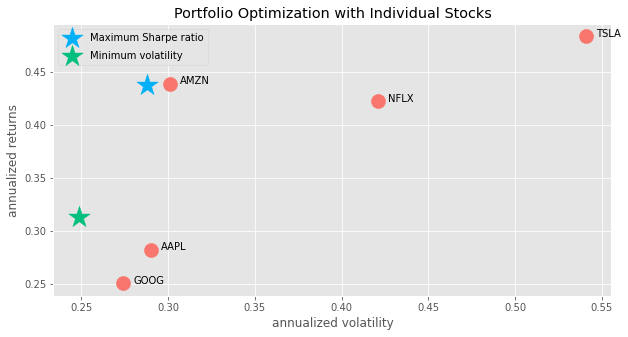

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(an_vol, an_rt, marker="o", color="#f8766d", s=200)

for i, txt in enumerate(data.columns):
    ax.annotate(txt, (an_vol[i], an_rt[i]), xytext=(10, 0), textcoords="offset points")

ax.scatter(sdp, rp, marker="*", color="#01b0f6", s=500, label="Maximum Sharpe ratio")
ax.scatter(sdp_min, rp_min, marker="*", color="#02bf7d", s=500, label="Minimum volatility")

#target = np.linspace(rp_min, 0.34, 50)
#efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

#ax.plot([pf["fun"] for pf in efficient_portfolios], target, linestyle="-.", color="black", label="efficient frontier")
ax.set_title("Portfolio Optimization with Individual Stocks")
ax.set_xlabel("annualized volatility")
ax.set_ylabel("annualized returns")
ax.legend(labelspacing=0.8)
plt.show(fig)

In [33]:
df_test = pdr.get_data_yahoo(list(data.columns), start=date.today()-timedelta(365))["Adj Close"]

[*********************100%***********************]  5 of 5 completed


In [34]:
ret_sharpe = 0
for i in df_test.columns:
    ret_sharpe += df_test[i]*max_sharpe_allocation.reset_index(drop=True)[i][0]
ret_sharpe /= 100

ret_vol = 0
for i in df_test.columns:
    ret_vol += df_test[i]*min_vol_allocation.reset_index(drop=True)[i][0]
ret_vol /= 100

In [35]:
df_test["MSP"] = ret_sharpe
df_test["MVP"] = ret_vol

In [36]:
if df_test.isna().sum().sum() > 0:
    df_test = df_test.dropna()

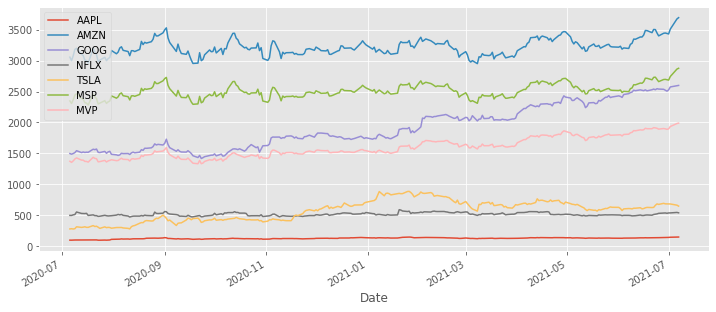

In [37]:
df_test.plot(figsize=(12,5),legend=True)
plt.show()

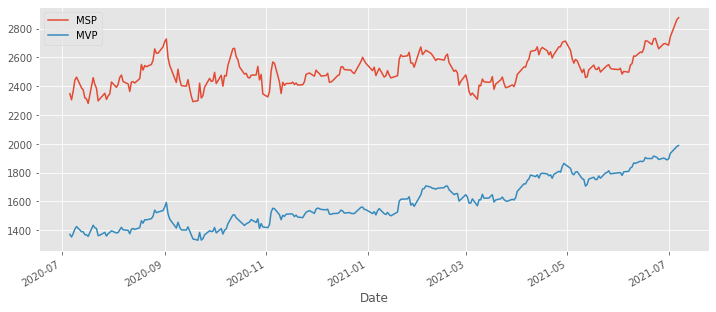

In [38]:
df_test[["MSP", "MVP"]].plot(figsize=(12,5),legend=True)
plt.show()

In [39]:
(df_test["MSP"][-1] - df_test["MSP"][0])/df_test["MSP"][0] * 100

22.52208569210421

In [40]:
(df_test["MVP"][-1] - df_test["MVP"][0])/df_test["MVP"][0] * 100

45.0947100620939

In [41]:
df_test

,AAPL,AMZN,GOOG,NFLX,TSLA,MSP,MVP
Date,,,,,,,
2020-07-06,92.836960,3057.040039,1495.699951,493.809998,274.316010,2348.041871,1370.322781
2020-07-07,92.548889,3000.120117,1485.180054,493.160004,277.971985,2306.289129,1352.505092
2020-07-08,94.704369,3081.110107,1496.000000,502.779999,273.175995,2366.576044,1376.910929
2020-07-09,95.111641,3182.629883,1510.989990,507.760010,278.855988,2442.997308,1407.443263
2020-07-10,95.278015,3200.000000,1541.739990,548.729980,308.929993,2463.439481,1425.139097
...,...,...,...,...,...,...,...
2021-06-30,136.960007,3440.159912,2506.320068,528.210022,679.700012,2690.607108,1888.443911
2021-07-01,137.270004,3432.969971,2527.370117,533.539978,677.919983,2685.518274,1895.287727
2021-07-02,139.960007,3510.979980,2574.379883,533.979980,678.900024,2743.589847,1933.591985
